# Module 9: Convolutional Neural Networks
## **Lab 3**
### Module coordinator: Kushagra Agarwal

## 1. Understanding Convolutions

<img src="https://miro.medium.com/max/464/0*e-SMFTzO8r7skkpc" width=650px/>

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Importing some pytorch packages
import torch
from torch.nn import Conv2d

Central to CNNs, a convolution operation is a linear element-wise multiplication operation between a small filter/kernel and same-sized patch from the image. We move this filter over the image like a sliding window from top left to bottom right. For each point on the image, a value is calculated based on the filter using a convolution operation. These filters can do simplest task like checking if there is a vertical line in the image or complicated task like detecting a human eye in the image. 

Let's look at the convolution formula:

Convolution between image 
$f(x, y)$ and kernel $k(x, y)$ is
$$f(x,y) * k(x,y) = \sum \limits _{i=0} ^{W-1} \sum \limits _{j=0} ^{H-1} f(i, j) k(x − i, y − j)$$

where $W$ and $H$ are the the width and height of the image.

The code demonstrates the convolution operation of a 2D matrix (image) with various filters

<img src="https://www.researchgate.net/profile/Chaim-Baskin/publication/318849314/figure/fig1/AS:614287726870532@1523469015098/Image-convolution-with-an-input-image-of-size-7-7-and-a-filter-kernel-of-size-3-3.png" alt="Convolution" width=650px height=280px/>

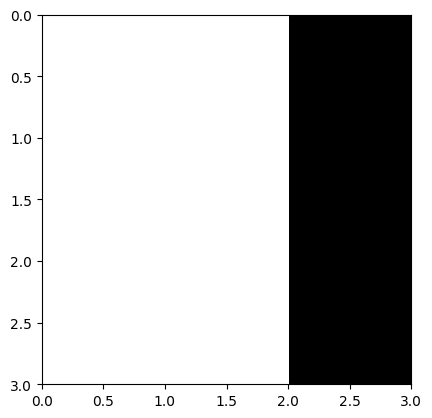

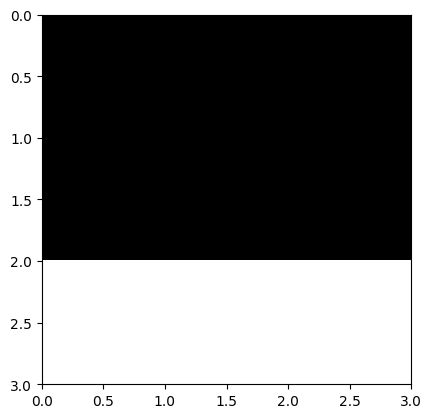

In [ ]:
# 2D 3x3 binary image with vertical edge
image1 = np.array([[1,1,0], [1,1,0], [1,1,0]])

# 2D 3x3 binary image with horizontal edge
image2 = np.array([[0,0,0], [0,0,0], [1,1,1]])

# On plotting the images
plt.imshow(image1, cmap='gray', extent=[0, 3, 3, 0])
plt.show()
plt.imshow(image2, cmap='gray', extent=[0, 3, 3, 0])
plt.show()

In [ ]:
# Vertical Line filter
filter = np.array([[1,0,-1],
                   [1,0,-1],
                   [1,0,-1]])

# Applying filter to first image
output = np.sum(np.multiply(image1, filter))
print('Output from first image: ', output)

# Applying filter to second image
output = np.sum(np.multiply(image2, filter))
print('Output from second image: ', output)

Output from first image:  3
Output from second image:  0


In [ ]:
# Horizontal edge filter
filter = np.array([[-1,-1,-1],
                   [ 0, 0, 0],
                   [ 1, 1, 1]])

output = np.sum(np.multiply(image1, filter))
print('Output from first image: ', output)

output = np.sum(np.multiply(image2, filter))
print('Output from second image: ', output)

Output from first image:  0
Output from second image:  3


Non-zero output suggests that there is a vertical edge present in the first image and not present in the second image. Similarly, horizontal edge is detected in second.

Let's define a function to use convolution layer from Pytorch and use our own kernel to detect edges in image

In [ ]:
def apply_conv(image, kernel, padding=0, stride=1):

  #--------IMAGE PREPROCESSING-------
  image = torch.from_numpy(image)
  # Pytorch requires input to convolution in (N,C,H,W), where N = batch size and C=#channels in input
  input = image.view((1,1,image.shape[0], image.shape[1]))

  # --------------KERNEL-------------
  kernel = torch.from_numpy(kernel.astype(np.float32))

  # Pytorch requires kernel of shape (N,C,H,W), where N = batch size and C=#channels in input
  kernel = kernel.view((1,1,kernel.shape[0], kernel.shape[1]))

  # ---------CONVOLUTION LAYER from Pytorch--------
  conv = Conv2d(in_channels=1, out_channels=1, kernel_size=kernel.shape, padding=padding, stride=stride)

  # Set the kernel weights in the convolution layer
  conv.weight = torch.nn.Parameter(kernel)
  
  # ---------APPLY CONVOLUTION--------
  output = conv(input.float())
  output_img = output.data.numpy()  # Tensor to back in numpy
  output_img = output_img.reshape((-1, output_img.shape[-1])) # Reshape to 2D image

  return output_img

In [ ]:
# Our original lotus image
image = cv2.imread('/content/grid1 (1).jpg', 0)

filter = np.array([[-1,-1,-1],
                   [ 0, 0, 0],
                   [ 1, 1, 1]])

out1 = apply_conv(image, filter, padding=0, stride=1)

filter = np.array([[1,0,-1],
                   [1,0,-1],
                   [1,0,-1]])

out2 = apply_conv(image, filter, padding=0, stride=1)

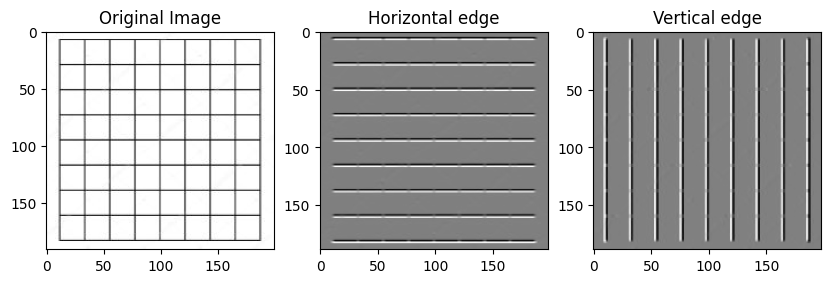

In [ ]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,3,1)
ax.imshow(image, cmap='gray')
ax.set_title('Original Image')
ax = fig.add_subplot(1,3,2)
ax.set_title('Horizontal edge')
ax.imshow(out1, cmap='gray')
ax = fig.add_subplot(1,3,3)
ax.imshow(out2, cmap='gray')
ax.set_title('Vertical edge')
plt.show()


## Pooling Layers

Pooling layers are used to reduce the dimensions of the feature maps. Thus, it reduces the number of parameters to learn and the amount of computation performed in the network. The pooling layer summarises the features present in a region of the feature map generated by a convolution layer.

1) Max Pooling:

<img src='https://media.geeksforgeeks.org/wp-content/uploads/20190721025744/Screenshot-2019-07-21-at-2.57.13-AM.png' height=150px/>

2) Average Pooling:

<img src='https://media.geeksforgeeks.org/wp-content/uploads/20190721030705/Screenshot-2019-07-21-at-3.05.56-AM.png' height=150px/>

## Softmax layer/activation
Recall that logistic regression produces a decimal between 0 and 1.0. For example, a logistic regression output of 0.8 from an email classifier suggests an 80% chance of an email being spam and a 20% chance of it being not spam. Clearly, the sum of the probabilities of an email being either spam or not spam is 1.0.

Softmax extends this idea into a multi-class world. That is, Softmax assigns decimal probabilities to each class in a multi-class problem. Those decimal probabilities must add up to 1.0. This additional constraint helps training converge more quickly than it otherwise would.
Softmax is implemented through a neural network layer just before the output layer. The Softmax layer must have the same number of nodes as the output layer.

<img src='https://miro.medium.com/max/1400/1*ReYpdIZ3ZSAPb2W8cJpkBg.jpeg' height=170px />

## Learning to train a CNN network

In [9]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [10]:
#  Images returned from torchvision dataset classes is in range [0,1]
# We transform them to tensors and normalize them to range [-1,1] using 'Normalize' transform

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# Classes in CIFAR10
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:02<00:00, 77003792.06it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [11]:
print('Training data shape : ', trainset.data.shape, len(trainset.targets))
print('Testing data shape : ', testset.data.shape, len(testset.targets))

# Find the unique numbers from the train labels
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Training data shape :  (50000, 32, 32, 3) 50000
Testing data shape :  (10000, 32, 32, 3) 10000
Total number of outputs :  10
Output classes :  ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [12]:
def train(num_epochs, model, train_loader, loss_func, optimizer):

  # Training mode
  model.train()

  train_losses = []
  train_acc = []

  # Train the model
  for epoch in range(num_epochs):
    running_loss = 0
    running_acc = 0
    for i, (images, labels) in enumerate(train_loader):
      
      # clear gradients for this training step   
      optimizer.zero_grad()           

      # Forward pass
      output = model(images)

      # Calculate loss
      loss = loss_func(output, labels)

      # Backpropagation, compute gradients 
      loss.backward()

      # Apply gradients             
      optimizer.step()                
      
      # Running loss
      running_loss += loss.item()

      # indices of max probabilities
      _, preds = torch.max(output, dim=1)

      # Calculate number of correct predictions
      correct = (preds.float() == labels).sum()
      running_acc += correct

      # Average loss and acc values 
      epoch_loss = running_loss / len(train_loader.dataset)
      epoch_acc = running_acc / len(train_loader.dataset)

    train_losses.append(epoch_loss)
    train_acc.append(epoch_acc)
    print ('Epoch {}/{}, Loss: {:.4f}, Accuracy: {:.4f}'.format(epoch + 1, num_epochs, epoch_loss, epoch_acc*100))

  return train_losses, train_acc

In [13]:
def test_model(model, testloader):
  correct = 0
  total = 0
  # Deactivate autograd engine (don't compute grads since we're not training)
  with torch.no_grad():
    for data in testloader:
        images, labels = data
        # Calculate outputs by running images through the network
        outputs = model(images)
        # The class with the highest value is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

  print('Accuracy of the network: %d %%' % (
      100 * correct / total))

In [14]:
# CNN with 2 CONV layers and 3 FC layers
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 5 * 5, 512)
        self.fc2 = nn.Linear(512, 128)
        # output layer 10 classes
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # flatten all dimensions except batch
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [15]:
model = Net()
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [16]:
# Cross Entropy loss for multi-class classification
criterion = nn.CrossEntropyLoss()

In [17]:
# SGD optimizer with momentum
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)

In [18]:
num_epochs = 5  # iterations
train_losses, train_acc = train(num_epochs, model, trainloader, criterion, optimizer)

Epoch 1/5, Loss: 0.0131, Accuracy: 39.0040
Epoch 2/5, Loss: 0.0093, Accuracy: 57.4660
Epoch 3/5, Loss: 0.0077, Accuracy: 65.3940
Epoch 4/5, Loss: 0.0066, Accuracy: 70.1700
Epoch 5/5, Loss: 0.0057, Accuracy: 74.4320


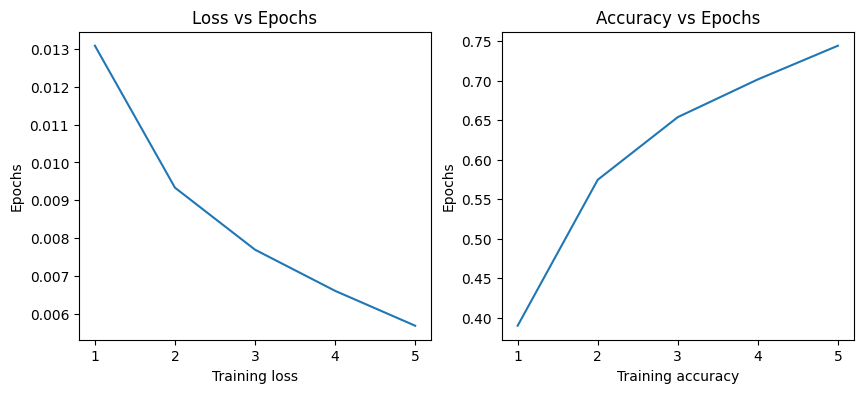

In [19]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2, 1)
ax.plot(np.arange(1,len(train_losses)+1),train_losses)
plt.xlabel('Training loss')
plt.ylabel('Epochs')
ax.set_title('Loss vs Epochs')
ax = fig.add_subplot(1,2, 2)
ax.plot(np.arange(1,len(train_acc)+1),train_acc)
plt.xlabel('Training accuracy')
plt.ylabel('Epochs')
ax.set_title('Accuracy vs Epochs')
plt.show()

In [20]:
# Accuracy on test data after training
test_model(model, testloader)

Accuracy of the network: 68 %


## Questions
1) List some reasons why we should prefer CNN over ANN for image classification?

2) Try improving the CNN performance further by tuning the hyperparameters(epochs, optimizer, LR etc). Report the improved test accuracy.

3) What happens if you reduce the number of convolution layers to only 1?

4) Why didn't we use the Softmax activation in the last layer of CNN?


**Answers**

2.Try improving the CNN performance further by tuning the hyperparameters (epochs, optimizer, LR etc). Report the improved test accuracy.

======================== Learning Rate = 0.1 =========================
Epoch 1/5, Loss: 0.0180, Accuracy: 11.1660
Epoch 2/5, Loss: 0.0180, Accuracy: 11.1660
Epoch 3/5, Loss: 0.0180, Accuracy: 11.1660
Epoch 4/5, Loss: 0.0180, Accuracy: 11.1660
Epoch 5/5, Loss: 0.0180, Accuracy: 11.1660


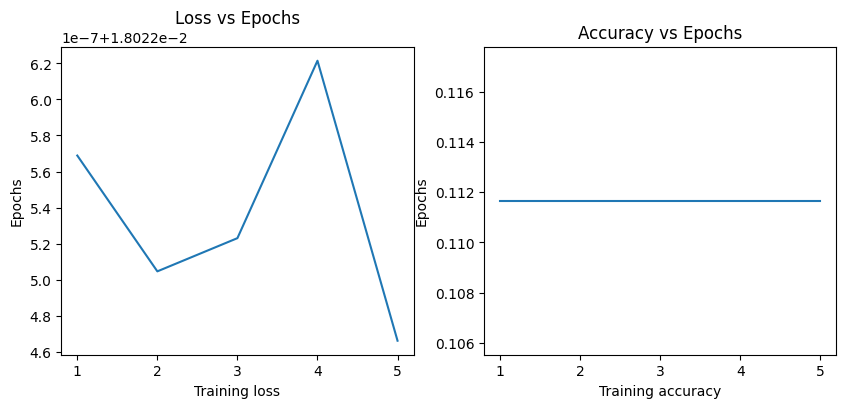

Accuracy of the network: 10 %
======================== Learning Rate = 0.01 =========================
Epoch 1/5, Loss: 0.0180, Accuracy: 10.0000
Epoch 2/5, Loss: 0.0180, Accuracy: 10.0000
Epoch 3/5, Loss: 0.0180, Accuracy: 10.0000
Epoch 4/5, Loss: 0.0180, Accuracy: 10.0000
Epoch 5/5, Loss: 0.0180, Accuracy: 10.0000


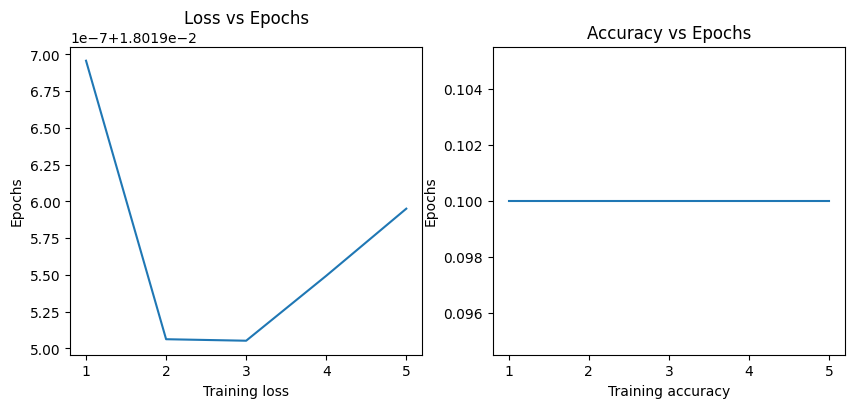

Accuracy of the network: 10 %
======================== Learning Rate = 0.0001 =========================
Epoch 1/5, Loss: 0.0180, Accuracy: 10.0480
Epoch 2/5, Loss: 0.0180, Accuracy: 10.0480
Epoch 3/5, Loss: 0.0180, Accuracy: 10.0480
Epoch 4/5, Loss: 0.0180, Accuracy: 10.0480
Epoch 5/5, Loss: 0.0180, Accuracy: 10.0480


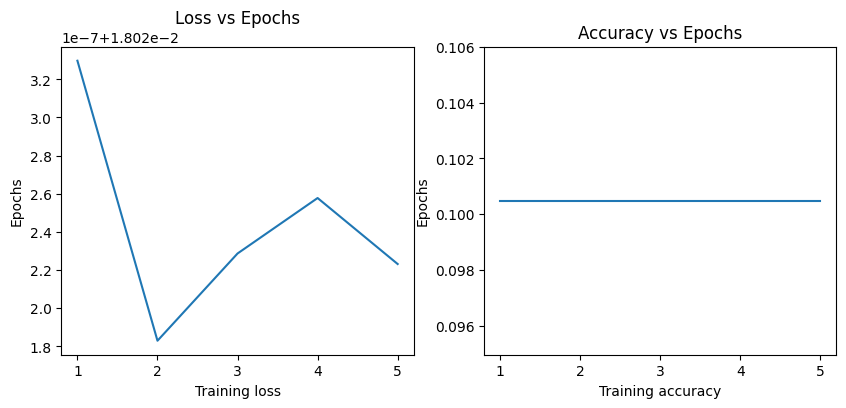

Accuracy of the network: 10 %


In [21]:
# SGD optimizer with momentum
lrs = [0.1, 0.01, 0.0001]
num_epochs = 5  # iterations
for lr in lrs:
  print(f"======================== Learning Rate = {lr} =========================")
  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
  criterion = nn.CrossEntropyLoss()
  model = Net()
  train_losses, train_acc = train(num_epochs, model, trainloader, criterion, optimizer)
  fig = plt.figure(figsize=(10,4))
  ax = fig.add_subplot(1,2, 1)
  ax.plot(np.arange(1,len(train_losses)+1),train_losses)
  plt.xlabel('Training loss')
  plt.ylabel('Epochs')
  ax.set_title('Loss vs Epochs')
  ax = fig.add_subplot(1,2, 2)
  ax.plot(np.arange(1,len(train_acc)+1),train_acc)
  plt.xlabel('Training accuracy')
  plt.ylabel('Epochs')
  ax.set_title('Accuracy vs Epochs')
  plt.show()
  # Accuracy on test data after training
  test_model(model, testloader)

3.What happens if you reduce the number of convolution layers to only 1?

In [22]:
# CNN with 2 CONV layers and 3 FC layers
class Net_Conv1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        # self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(3600, 512)
        self.fc2 = nn.Linear(512, 128)
        # output layer 10 classes
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        # x = self.pool(F.relu(self.conv2(x)))
        # flatten all dimensions except batch
        x = torch.flatten(x, 1)

        # print(x.size())

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Epoch 1/5, Loss: 0.0180, Accuracy: 9.9380
Epoch 2/5, Loss: 0.0180, Accuracy: 9.9380
Epoch 3/5, Loss: 0.0180, Accuracy: 9.9380
Epoch 4/5, Loss: 0.0180, Accuracy: 9.9380
Epoch 5/5, Loss: 0.0180, Accuracy: 9.9380


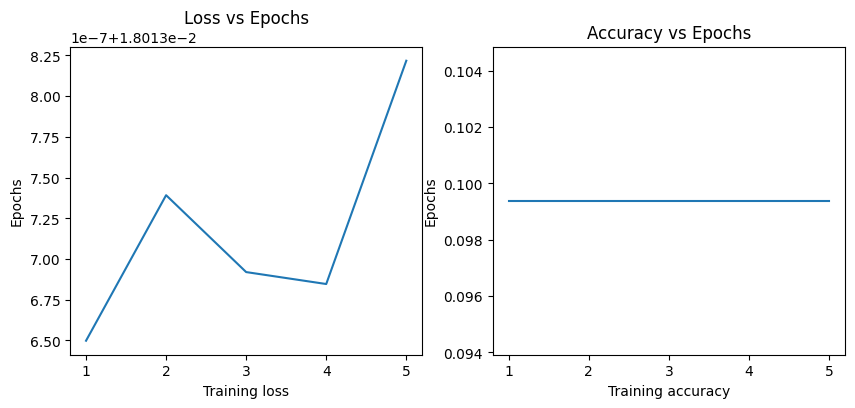

In [23]:
num_epochs = 5
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
model = Net_Conv1()
train_losses, train_acc = train(num_epochs, model, trainloader, criterion, optimizer)
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2, 1)
ax.plot(np.arange(1,len(train_losses)+1),train_losses)
plt.xlabel('Training loss')
plt.ylabel('Epochs')
ax.set_title('Loss vs Epochs')
ax = fig.add_subplot(1,2, 2)
ax.plot(np.arange(1,len(train_acc)+1),train_acc)
plt.xlabel('Training accuracy')
plt.ylabel('Epochs')
ax.set_title('Accuracy vs Epochs')
plt.show()
     

In [24]:
# Accuracy on test data after training
test_model(model, testloader)

Accuracy of the network: 9 %


Accuracy of model is not improving substatially if we just used one convolutional layer.

4.Why didn't we use the Softmax activation in the last layer of CNN?
In PyTorch, the softmax layer is already 

* In PyTorch, the softmax layer is already coupled with Cross Entropy Function. Reference


* Softmax is not a mandatory layer. It helps to converge faster than it would otherwise.  




1.List some reasons why we should prefer CNN over ANN for image classification?

Answer:
CNNs are typically preferred over ANNs for image classification tasks because they're designed to capture the spatial structure of photos and automatically extract relevant characteristics¹. CNNs use convolutional layers to recognize patterns in pictures, such as edges, lines, and forms¹. The main advantage of CNN is that it automatically detects the important features without any human supervision⁴. This makes CNN ideal when thousands of features need to be extracted².
